In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score
import seaborn as sns

In [305]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# train.fillna(method='ffill',inplace=True)

In [306]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [307]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [308]:
print('train shape:',train.shape)
print(train.isnull().sum())
print('--------------------------------')
print('test shape:',test.shape)
print(test.isnull().sum())

train shape: (891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------------------
test shape: (418, 11)
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [10]:
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower
# age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
# sibsp: The dataset defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)
# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

# survived  是否生存
# Pclass    社会经济地位的代表
# Name      姓名
# Sex       性别
# Age       年龄
# SibSp     家庭关系的字段，我理解的是兄弟姐妹的个数，1/0出现次数最多，5:5 8:7 5和8 有可能是异常数据
# Parch     家庭关系的字段，我理解的是陪伴的家人
# Ticket    门票编号
# Fare      票价
# Cabin     客舱编号
# Emarked   登船港口

In [309]:
print(df.columns)
print('Pclass',Counter(df['Pclass']))
print('Sex',Counter(df['Sex']))
print('SibSp',Counter(df['SibSp']))
print('Parch',Counter(df['Parch']))
print('Embarked',Counter(df['Embarked']))
# print('Cabin',Counter(df['Cabin']))


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Pclass Counter({3: 491, 1: 216, 2: 184})
Sex Counter({'male': 577, 'female': 314})
SibSp Counter({0: 608, 1: 209, 2: 28, 4: 18, 3: 16, 8: 7, 5: 5})
Parch Counter({0: 678, 1: 118, 2: 80, 5: 5, 3: 5, 4: 4, 6: 1})
Embarked Counter({'S': 644, 'C': 169, 'Q': 78})


# detect outlier

In [284]:
# features = ['Age','SibSp','Parch','Fare']
col = 'Age'
col = 'Fare'
col = 'SibSp'
col = 'Parch'
print('max',np.max(df[col]))
print('min',np.min(df[col]))
q1 = np.percentile(df[col],25)
q3 = np.percentile(df[col],75)
iqr = (q3 - q1) * 1.5
down = q1 - iqr
up = q3 + iqr
print('down',down)
print('up',up)
outlier_index = df[(df[col]<down)|(df[col]>up)].index
print('length of index:',len(outlier_index))

#Parch down和up都是0,这个地方有点奇怪

max 6
min 0
down 0.0
up 0.0
length of index: 213


In [311]:
def detect_outlier(df,n,features):
    outlier_indices = []
    for col in features:
        q1 = np.percentile(df[col],25)
        q3 = np.percentile(df[col],75)
        iqr = (q3 - q1) * 1.5
        down = q1 - iqr
        up = q3 + iqr
        outlier_index = df[(df[col]<down)|(df[col]>up)].index
        outlier_indices.extend(outlier_index)
    
    multi_outlier = [index for index,numbers in Counter(outlier_indices).items() if numbers > n]
    return multi_outlier

outliers_to_drop = detect_outliers(df,2,['Age','SibSp','Parch','Fare'])
print('length of outlier_to_drop',len(outliers_to_drop))

length of outlier_to_drop 81


In [312]:
print('Before drop:',train.shape)
train.drop(outliers_to_drop,inplace=True)
print('After drop:',train.shape)

Before drop: (891, 12)
After drop: (810, 12)


### joining train and test set

In [310]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### check for null and missing values

In [220]:
# Fill empty and NaNs values with Nan
dataset = dataset.fillna(np.nan)
# Check for Null values
dataset.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          328
Embarked         0
dtype: int64

In [290]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  810 non-null    int64  
 1   Survived     810 non-null    int64  
 2   Pclass       810 non-null    int64  
 3   Name         810 non-null    object 
 4   Sex          810 non-null    object 
 5   Age          644 non-null    float64
 6   SibSp        810 non-null    int64  
 7   Parch        810 non-null    int64  
 8   Ticket       810 non-null    object 
 9   Fare         810 non-null    float64
 10  Cabin        165 non-null    object 
 11  Embarked     808 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.3+ KB


In [291]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,810.000000,810.000000,810.000000,644.000000,810.000000,810.000000,810.000000
mean,447.045679,0.385185,2.338272,30.472438,0.307407,0.261728,25.674171
std,256.301823,0.486940,0.811927,13.712777,0.540630,0.724388,38.690805
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.250000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,450.500000,0.000000,3.000000,29.000000,0.000000,0.000000,13.000000
75%,666.750000,1.000000,3.000000,38.000000,1.000000,0.000000,26.550000
max,891.000000,1.000000,3.000000,80.000000,3.000000,6.000000,512.329200


# Feature Analysis

### Numerical Values

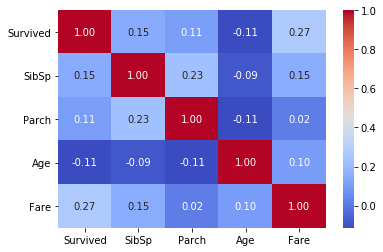

In [209]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


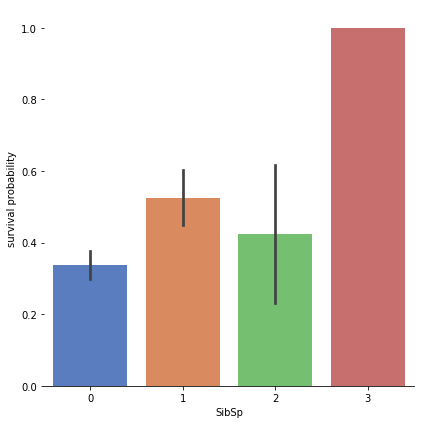

In [210]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")



It seems that passengers having a lot of siblings/spouses have less chance to survive

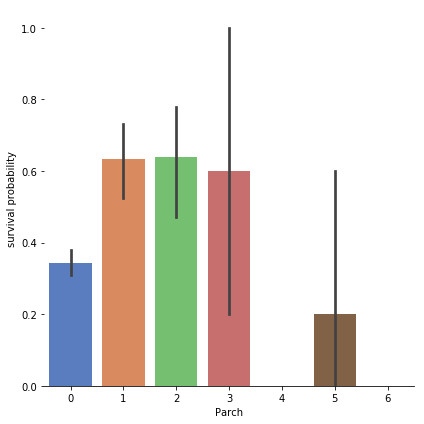

In [211]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

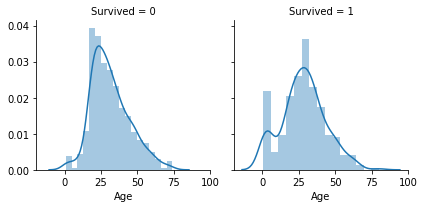

In [214]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")


Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived. 

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

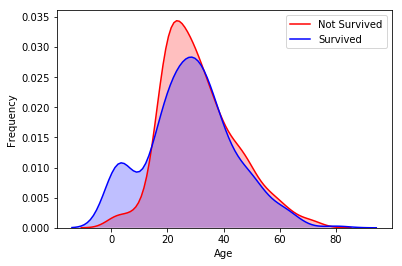

In [215]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [224]:
print(dataset['Fare'].isnull().sum())
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())


1


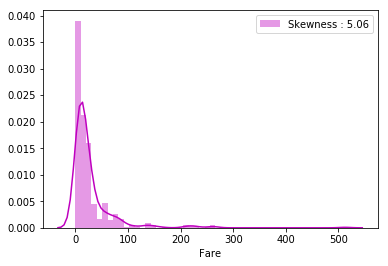

In [230]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled. 

In this case, it is better to transform it with the log function to reduce this skew. 

In [232]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i:np.log(i) if i>0 else 0)

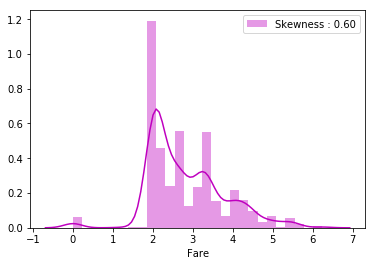

In [233]:
# Explore Fare distribution after apply log to Fare
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# Categorical values

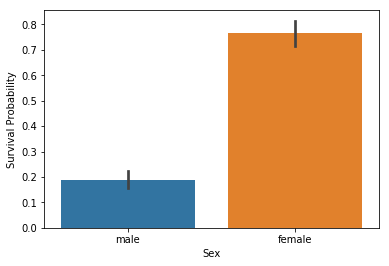

In [234]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

It is clearly obvious that Male have less chance to survive than Female

/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


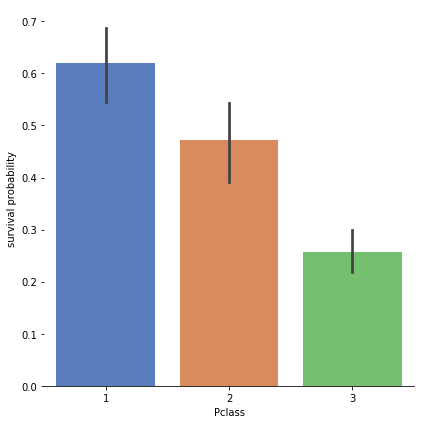

In [241]:
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

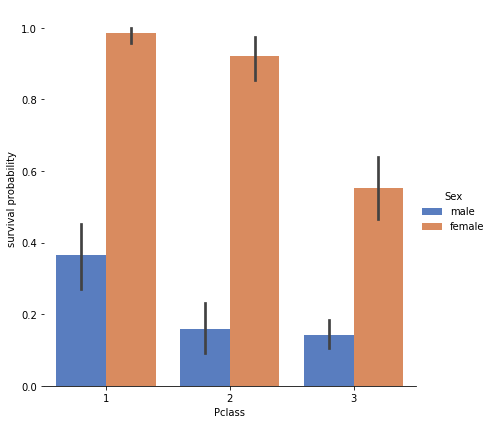

In [242]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female passengers.

In [296]:
dataset['Embarked'].isnull().sum()
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

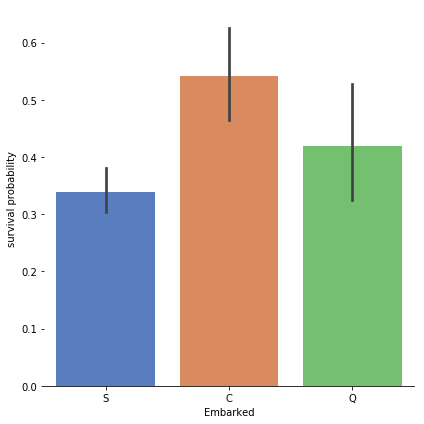

In [249]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

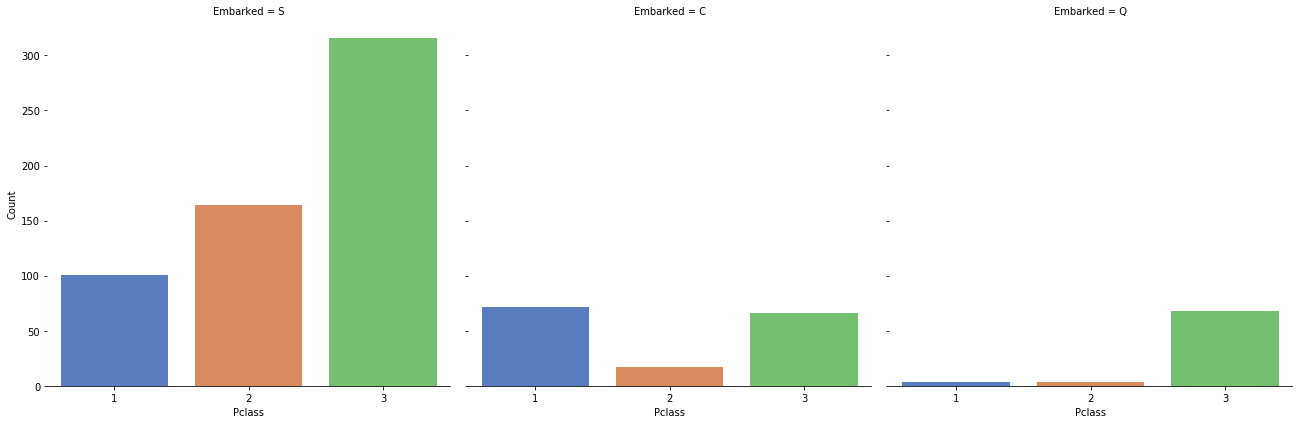

In [244]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

# Filling missing value
### Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

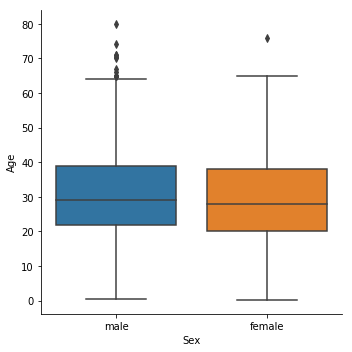

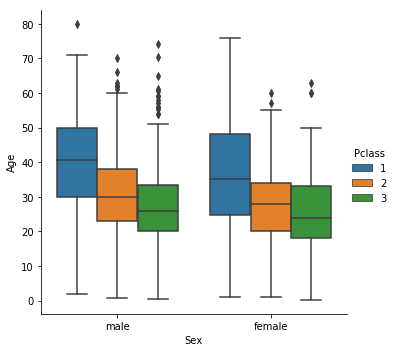

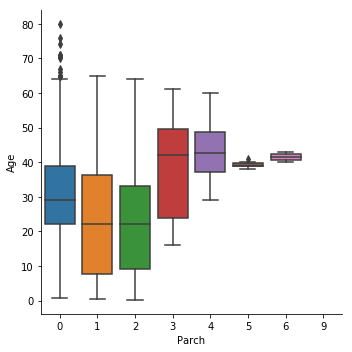

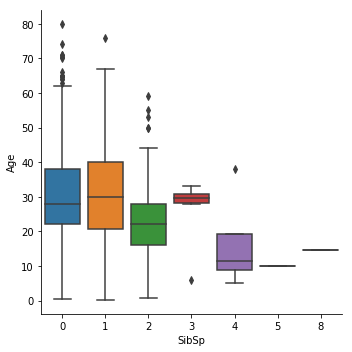

In [250]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [302]:
#convert Sex into Categorical value 0 for male and 1 for female
dataset["Sex"] = dataset['Sex'].map({"male":0,'female':1})

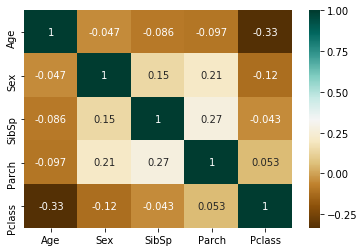

In [303]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

The correlation map confirms the factorplots observations except for Parch.Age is not correlated with Sex,but is negatively correlated with Pclass,Parch and SibSp.
    In the plot of Age in function of Parch,Age is growing with the number of parents/children.But the general correlation is negative.

So,I decided to use SibSp,Parch and Pclass in order to impute the missing ages.

The Strategy is to fill Age with the median age of similar rows according to Pclass,Parch and SibSp

In [322]:
index_nan_age = list(dataset['Age'][dataset['Age'].isnull()].index)

In [335]:
for i in index_nan_age:
    age_median = df['Age'].median()
    sibsp,parch,pclass = dataset['SibSp'].iloc[i],dataset['Parch'].iloc[i],dataset['Pclass'].iloc[i] 
    # print('sibsp:%d Parch:%d Pclass:%d' % (sibsp,parch,pclass))
    age_pred = dataset['Age'][(dataset['SibSp']==sibsp) & (dataset['Parch'] == parch) & (df['Pclass']==pclass)].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_median

/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


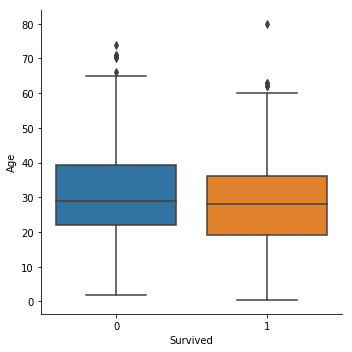

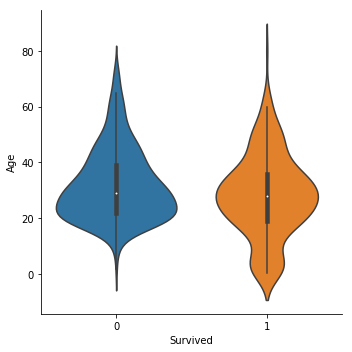

In [336]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation
But in the violin plot of survived passengers,we still notice that very young passengers have higher survival rate